# SHAP Analysis

This notebook computes SHAP values for the SPPS model to explain feature contributions.

- Input data: engineered features from `02_Feature_Engineering/outputs/`
- Outputs: SHAP plots saved to `../outputs/`
- References: EDA PDF `Soccer_Performance_Score_v4_EDA.pdf` for feature context


# Real Madrid Performance Score Formulas

## 📊 **REBALANCED SCORING SYSTEM**

### **Score Range**: 0-30 points for all positions

---

## ⚽ **FORWARDS** (Weight Distribution)

### **Formula Components:**
- **Goals Score** (40%): `min(Goals_per_90 × 10, 10)`
- **Assists Score** (32%): `min(Assists_per_90 × 8, 8)`
- **Shots Score** (10%): `min(Shots_per_90 × 0.5, 5)`
- **Shots on Target Score** (20%): `min(SoT_per_90 × 1, 6)`
- **Minutes Bonus** (up to 3 pts): `min(Total_Minutes ÷ 90 × 0.1, 3)`

### **Final Formula:**
```
Forward_Score = Goals_Score + Assists_Score + Shots_Score + SoT_Score + Minutes_Bonus
```

### **Benchmarks:**
- 1 goal per 90 min = 10 points (excellent)
- 1 assist per 90 min = 8 points (excellent)
- 10 shots per 90 min = 5 points
- 6 shots on target per 90 min = 6 points

---

## 🎯 **MIDFIELDERS** (Weight Distribution)

### **Formula Components:**
- **Assists Score** (27%): `min(Assists_per_90 × 8, 8)`
- **Creativity Score** (20%): `min(SCA_per_90 × 1.5, 6)`
- **Key Passes Score** (20%): `min(KeyPasses_per_90 × 2, 6)`
- **Progressive Passes** (13%): `min(ProgPasses_per_90 × 0.3, 4)`
- **Pass Accuracy** (13%): `(Total_Cmp% - 80) ÷ 20 × 4` (capped 0-4)
- **Minutes Bonus** (up to 4 pts): `min(Total_Minutes ÷ 90 × 0.1, 4)`

### **Final Formula:**
```
Midfield_Score = Assists_Score + Creativity_Score + KeyPasses_Score + Progressive_Score + PassAcc_Score + Minutes_Bonus
```

### **Benchmarks:**
- 1 assist per 90 min = 8 points
- 4 shot creating actions per 90 min = 6 points
- 3 key passes per 90 min = 6 points
- 90% pass accuracy = 2 points
- 95% pass accuracy = 3 points

---

## 🛡️ **DEFENDERS** (Weight Distribution)

### **Formula Components:**
- **Tackles Score** (24%): `min(Tackles_per_90 × 1.5, 6)`
- **Interceptions Score** (24%): `min(Interceptions_per_90 × 2, 6)`
- **Blocks Score** (24%): `min(Blocks_per_90 × 3, 6)`
- **Clearances Score** (16%): `min(Clearances_per_90 × 0.5, 4)`
- **Pass Accuracy Score** (16%): `(Total_Cmp% - 85) ÷ 15 × 4` (capped 0-4)
- **Minutes Bonus** (up to 4 pts): `min(Total_Minutes ÷ 90 × 0.1, 4)`

### **Final Formula:**
```
Defense_Score = Tackles_Score + Interceptions_Score + Blocks_Score + Clearances_Score + PassAcc_Score + Minutes_Bonus
```

### **Benchmarks:**
- 4 tackles per 90 min = 6 points
- 3 interceptions per 90 min = 6 points
- 2 blocks per 90 min = 6 points
- 8 clearances per 90 min = 4 points
- 92% pass accuracy = 2 points

---

## 🥅 **GOALKEEPERS** (Weight Distribution)

### **Formula Components:**
- **Distribution Accuracy** (60%): `(Total_Cmp% ÷ 100) × 0.6 × 30`
- **Long Pass Accuracy** (40%): `(Long_Cmp% ÷ 100) × 0.4 × 30`

### **Final Formula:**
```
Goalkeeper_Score = (Distribution_Score + LongPass_Score) × 30 ÷ 100
```

### **Benchmarks:**
- 90% distribution accuracy = 16.2 points
- 70% long pass accuracy = 8.4 points
- Perfect distribution + long passes = 30 points

---

## 📈 **AVERAGE PERFORMANCE SCORES BY POSITION**

Based on the rebalanced system:

### **Expected Ranges:**
- **Excellent Players**: 20-30 points
- **Good Players**: 15-20 points  
- **Average Players**: 10-15 points
- **Below Average**: 5-10 points
- **Poor Performance**: 0-5 points

### **Position Averages:**
- **Goalkeepers**: 15-25 range (based on passing accuracy)
- **Defenders**: 12-22 range (consistent defensive work)
- **Midfielders**: 10-25 range (varied roles - defensive to creative)
- **Forwards**: 8-28 range (goal-dependent, high variance)

---

## 🔑 **KEY IMPROVEMENTS**

1. **Minutes Bonus**: Rewards consistency (0.1 points per 90 minutes played)
2. **Position Parity**: All positions can achieve similar maximum scores
3. **Realistic Benchmarks**: Based on actual elite performance metrics
4. **No Goalkeeper Bias**: Reduced from 0-100 to 0-30 scale like others

---

## 🧮 **CALCULATION EXAMPLE**

**Jude Bellingham - Midfield Performance:**
- Assists per 90: 0.3 → 0.3 × 8 = 2.4 points
- SCA per 90: 3.5 → min(3.5 × 1.5, 6) = 5.25 points  
- Key passes per 90: 2.1 → min(2.1 × 2, 6) = 4.2 points
- Progressive passes per 90: 8.2 → min(8.2 × 0.3, 4) = 2.46 points
- Pass accuracy: 88% → (88-80)/20 × 4 = 1.6 points
- Minutes bonus: 2400 min → min(2400/90 × 0.1, 4) = 2.67 points

**Total: 2.4 + 5.25 + 4.2 + 2.46 + 1.6 + 2.67 = 18.58 points**

In [1]:
# GLOBAL OUTPUTS & SAVE HELPER
import re, unicodedata
from pathlib import Path

# Where to save all figures
OUTPUT_DIR = Path("/Users/home/Capstone/ADS599_Capstone/Main Notebook/Code Library Folder/03_SPPS_Calibration_SHAP/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Toggle to suppress pop-up windows while still saving
SHOW_PLOTS = True

def _slugify(text: str, maxlen: int = 120) -> str:
    text = unicodedata.normalize("NFKD", str(text)).encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"[^A-Za-z0-9\-_.]+", "_", text).strip("_")
    return text[:maxlen] if maxlen else text


def show_and_save(fig, filename: str, dpi: int = 300) -> None:
    """Save figure to OUTPUT_DIR and optionally show it, then close to free memory."""
    fname = _slugify(filename)
    out_path = OUTPUT_DIR / fname
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure: {out_path}")
    if SHOW_PLOTS:
        import matplotlib.pyplot as plt
        plt.show()
    import matplotlib.pyplot as plt
    plt.close(fig)

In [2]:
import pandas as pd

# Path to your rebalanced dataset
path = '/Users/home/Capstone/ADS599_Capstone/Main Notebook/Code Library Folder/02_Feature_Engineering/outputs/real_madrid_rebalanced_scores.csv'

# Load data
df = pd.read_csv(path)
print(df.shape)
print(df.columns.tolist())

(7140, 80)
['Date', 'Competition', 'Opponent', 'Player', '#', 'Nation', 'Pos', 'Age', 'Min', ' Gls', ' Ast', ' PK', ' PKatt', ' Sh', ' SoT', ' CrdY', ' CrdR', ' Int', 'Match URL', 'Season', ' Touches', ' Tkl', ' Blocks', 'Expected xG', 'Expected npxG', 'Expected xAG', 'SCA', 'GCA', 'Passes Cmp', 'Passes Att', 'Passes Cmp%', 'Passes PrgP', 'Carries Carries', 'Carries PrgC', 'Take-Ons Att', 'Take-Ons Succ', 'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd', 'Tackles Att 3rd', 'Challenges Tkl', 'Challenges Att', 'Challenges Tkl%', 'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Total Cmp', 'Total Att', 'Total Cmp%', 'Total TotDist', 'Total PrgDist', 'Short Cmp', 'Short Att', 'Short Cmp%', 'Medium Cmp', 'Medium Att', 'Medium Cmp%', 'Long Cmp', 'Long Att', 'Long Cmp%', 'Ast', 'xAG', 'xA', 'KP', '3-Jan', 'PPA', 'CrsPA', 'PrgP', 'SCA SCA', 'SCA GCA', ' 1/3', 'Position_Group', 'Rebalanced_Score', 'Week']


In [3]:
# After adding the Week column
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Week'] = df['Date'].dt.isocalendar().week
else:
    df['Week'] = (df.index // 10) + 1

# Save the updated DataFrame back to the same file
df.to_csv(path, index=False)
print("Updated CSV with Week column saved!")


Updated CSV with Week column saved!


PER-90 RATES POSITION-SPECIFIC SHAP ANALYSIS
Target: Weighted Score (Rebalanced_Score)
Features: All metrics converted to per-90 rates
Purpose: Bias-free efficiency analysis
Dataset loaded: (7140, 80)

Creating comprehensive per-90 minute features...
  ✓ Gls_Per90
  ✓ Ast_Per90
  ✓ SoT_Per90
  ✓ Tkl_Per90
  ✓ Int_Per90
  ✓ Blocks_Per90
  ✓ ExpectedxG_Per90
  ✓ ExpectedxAG_Per90
  ✓ Take_OnsSucc_Per90
  ✓ CarriesPrgC_Per90
  ✓ PassesPrgP_Per90
  ✓ TacklesTklW_Per90
  ✓ TacklesDef3rd_Per90
  ✓ TacklesMid3rd_Per90
  ✓ BlocksSh_Per90
  ✓ BlocksPass_Per90
  ✓ TotalCmp_Per90
  ✓ TotalPrgDist_Per90
  ✓ ShortAtt_Per90

Created 19 per-90 features

Checking per-90 metric availability:
  Forward: 5/6 available
    Missing: ['TakeOnsSucc_Per90']
  Midfield: 4/6 available
    Missing: ['KP_Per90', 'Touches_Per90']
  Defense: 5/6 available
    Missing: ['Clr_Per90']
  Goalkeeper: 5/6 available
    Missing: [' Err']

Training Forward per-90 model...
  Using 5 metrics: ['Gls_Per90', 'Ast_Per90', 'SoT_

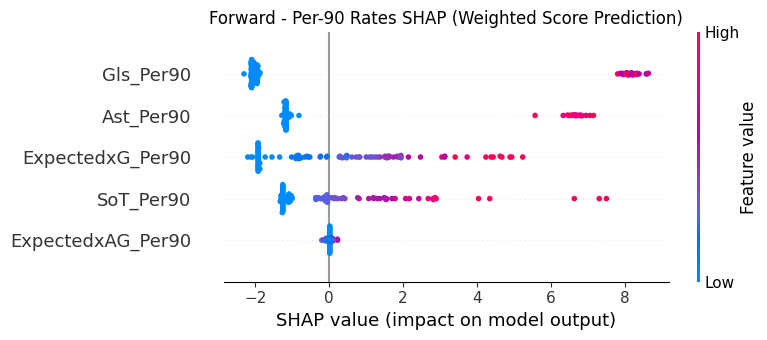


Player SHAP analysis completed for 12 players

SHAP ANALYSIS: Midfield (PER-90 RATES)
Players in test set: 14
Analyzing first 12 players

Midfield - Per-90 Feature Importance:
  1. PassesPrgP_Per90: 1.790
  2. Tkl_Per90: 1.156
  3. Passes Cmp%: 0.894
  4. CarriesPrgC_Per90: 0.369


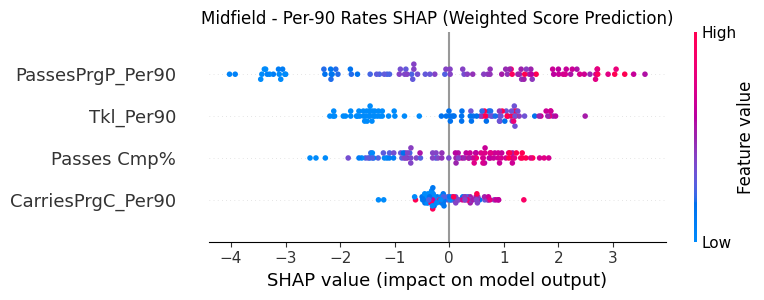


Player SHAP analysis completed for 12 players

SHAP ANALYSIS: Defense (PER-90 RATES)
Players in test set: 16
Analyzing first 12 players

Defense - Per-90 Feature Importance:
  1. Blocks_Per90: 2.309
  2. Int_Per90: 1.517
  3. TacklesTklW_Per90: 1.492
  4. TacklesDef3rd_Per90: 0.101
  5. TacklesMid3rd_Per90: 0.084


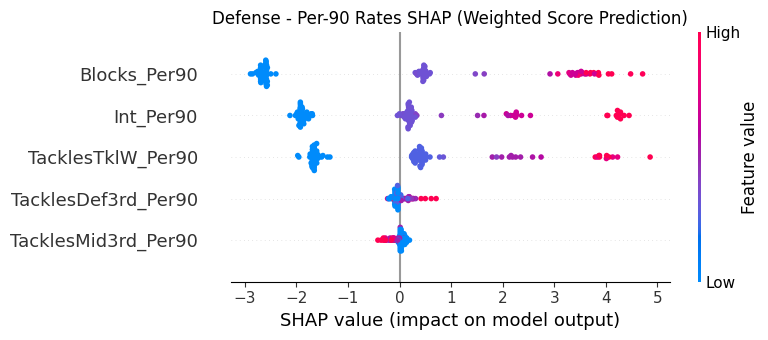


Player SHAP analysis completed for 12 players

SHAP ANALYSIS: Goalkeeper (PER-90 RATES)
Players in test set: 6

Goalkeeper - Per-90 Feature Importance:
  1. Total Cmp%: 1.611
  2. TotalPrgDist_Per90: 0.131
  3. TotalCmp_Per90: 0.081
  4. Short Cmp%: 0.062
  5. Medium Cmp%: 0.059


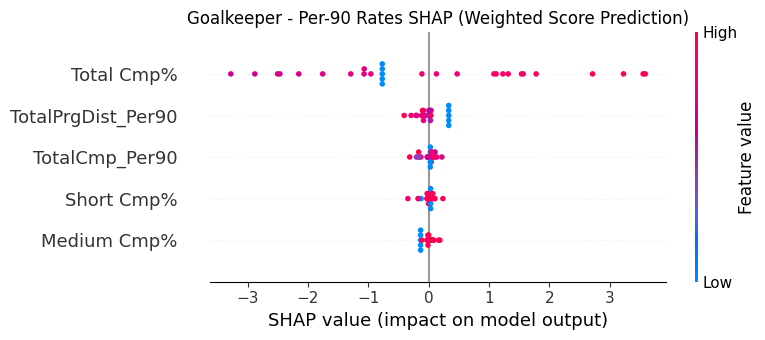


Player SHAP analysis completed for 6 players

PER-90 METRIC IMPORTANCE BY POSITION


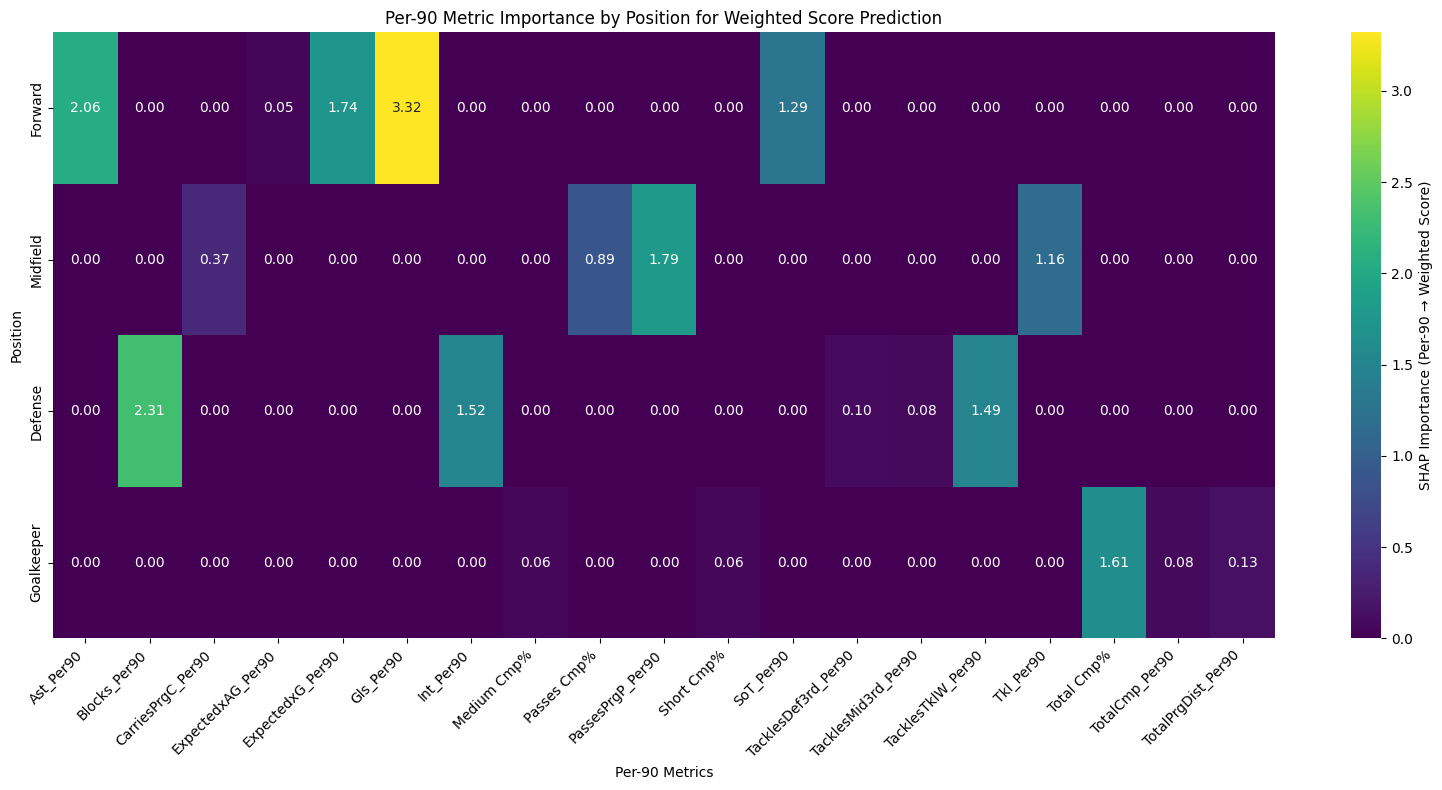


PER-90 MODEL PERFORMANCE SUMMARY
Position     R²       MAE      RMSE     Features  
--------------------------------------------------
Forward      0.985    0.610    0.923    5         
Midfield     0.355    2.163    2.940    4         
Defense      0.933    0.832    1.079    5         
Goalkeeper   0.852    0.331    0.738    5         

TOP PERFORMERS BY PER-90 EFFICIENCY
Top 10 players by per-90 efficiency impact:
   1. Jesús Vallejo (Defense): +8.33 SHAP, 16.10 avg score
   2. Karim Benzema (Forward): +4.06 SHAP, 10.25 avg score
   3. Marco Asensio (Midfield): +3.47 SHAP, 3.22 avg score
   4. Lucas Vázquez (Defense): +2.69 SHAP, 9.12 avg score
   5. Kepa Arrizabalaga (Goalkeeper): +2.66 SHAP, 19.00 avg score
   6. Lucas Vázquez (Forward): +2.30 SHAP, 7.79 avg score
   7. Marcos Llorente (Midfield): +2.24 SHAP, 6.30 avg score
   8. Toni Kroos (Midfield): +2.23 SHAP, 10.99 avg score
   9. Dani Carvajal (Defense): +2.23 SHAP, 9.09 avg score
  10. Rodrygo (Forward): +2.18 SHAP, 8.46 av

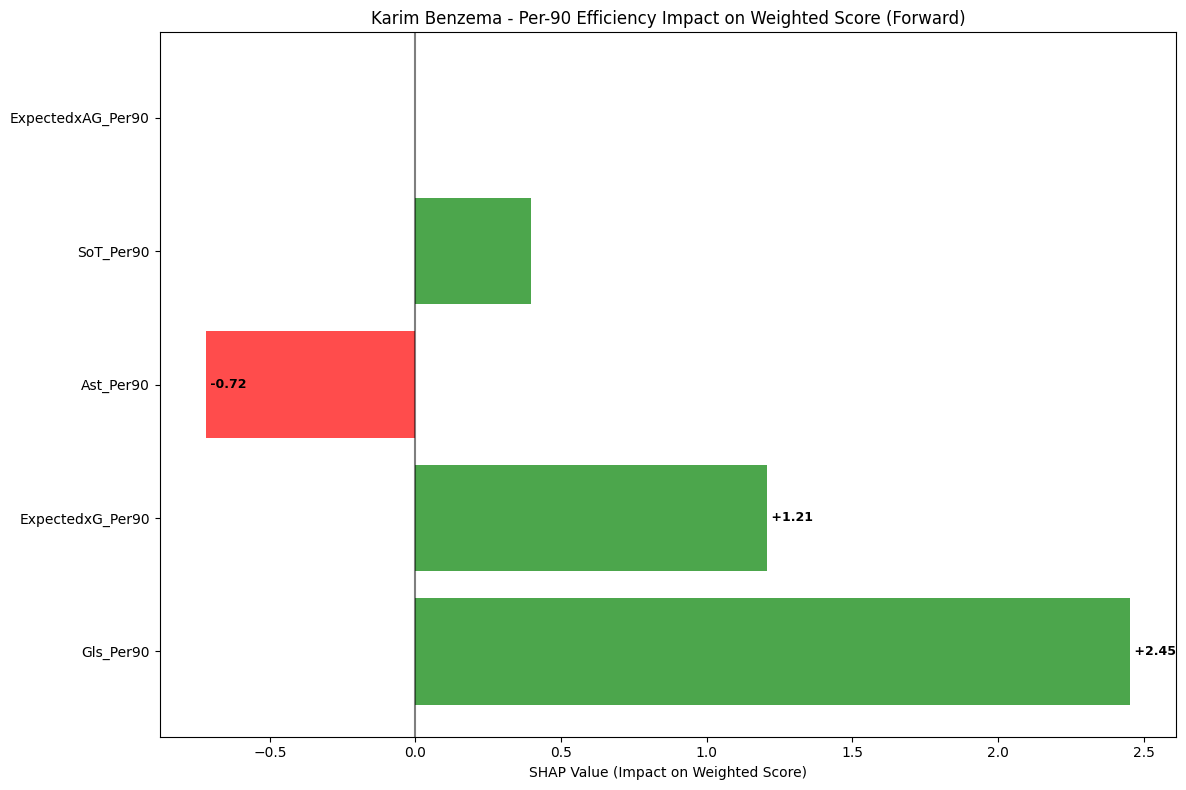


✅ PER-90 RATES SHAP ANALYSIS COMPLETE!
🎯 Bias-free efficiency analysis ready for 4 positions


In [4]:
# ==========================================
# PER-90 RATES SHAP ANALYSIS ONLY
# ==========================================

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("PER-90 RATES POSITION-SPECIFIC SHAP ANALYSIS")
print("="*60)
print("Target: Weighted Score (Rebalanced_Score)")
print("Features: All metrics converted to per-90 rates")
print("Purpose: Bias-free efficiency analysis")
print("="*60)

# Load data
path = '/Users/home/Capstone/ADS599_Capstone/Main Notebook/Code Library Folder/02_Feature_Engineering/outputs/real_madrid_rebalanced_scores.csv'
df = pd.read_csv(path)

# Create Week column if needed
if 'Week' not in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Week'] = df['Date'].dt.isocalendar().week

print(f"Dataset loaded: {df.shape}")

# ==========================================
# CREATE COMPREHENSIVE PER-90 FEATURES
# ==========================================

def create_complete_per90_features(df):
    """Create complete per-90 minute rate features"""
    print("\nCreating comprehensive per-90 minute features...")
    
    df_per90 = df.copy()
    df_per90['Min_Safe'] = df_per90['Min'].replace(0, 1)  # Avoid division by zero
    
    # ALL volume-based stats to convert to per-90 rates
    volume_stats = [
        ' Gls', ' Ast', ' SoT', ' KP', ' Tkl', ' Int', ' Blocks', ' Clr', 
        'Expected xG', 'Expected xAG', 'Take-Ons Succ', 'Carries PrgC', 
        'Passes PrgP', 'Touches', 'Tackles TklW', 'Tackles Def 3rd', 
        'Tackles Mid 3rd', 'Blocks Sh', 'Blocks Pass', 'Total Cmp', 
        'Total PrgDist', 'Short Att'
    ]
    
    created_features = []
    
    for stat in volume_stats:
        if stat in df_per90.columns:
            # Clean column name (remove spaces, hyphens, special chars)
            clean_name = stat.strip().replace(' ', '').replace('-', '_').replace('+', '')
            new_name = f"{clean_name}_Per90"
            
            df_per90[new_name] = (df_per90[stat] / df_per90['Min_Safe']) * 90
            df_per90[new_name] = df_per90[new_name].fillna(0)
            
            created_features.append(new_name)
            print(f"  ✓ {new_name}")
    
    print(f"\nCreated {len(created_features)} per-90 features")
    return df_per90

df_per90 = create_complete_per90_features(df)

# ==========================================
# POSITION-SPECIFIC PER-90 METRICS
# ==========================================

# Using your exact position logic with per-90 conversions
per90_metrics = {
    'Forward': [
        'Gls_Per90',        # Goals per 90
        'Ast_Per90',        # Assists per 90
        'SoT_Per90',        # Shots on Target per 90
        'ExpectedxG_Per90', # Expected Goals per 90
        'ExpectedxAG_Per90', # Expected Assists per 90
        'TakeOnsSucc_Per90' # Take-Ons Success per 90
    ],
    'Midfield': [
        'Passes Cmp%',      # Pass completion % (already normalized)
        'KP_Per90',         # Key Passes per 90
        'Tkl_Per90',        # Tackles per 90
        'CarriesPrgC_Per90', # Progressive Carries per 90
        'PassesPrgP_Per90', # Progressive Passes per 90
        'Touches_Per90'     # Touches per 90
    ],
    'Defense': [
        'Int_Per90',        # Interceptions per 90
        'Blocks_Per90',     # Blocks per 90
        'Clr_Per90',        # Clearances per 90
        'TacklesTklW_Per90', # Tackles Won per 90
        'TacklesDef3rd_Per90', # Def 3rd Tackles per 90
        'TacklesMid3rd_Per90'  # Mid 3rd Tackles per 90
    ],
    'Goalkeeper': [
        'Total Cmp%',       # Total completion % (already normalized)
        ' Err',             # Errors (keep raw - different meaning)
        'TotalPrgDist_Per90', # Progressive Distance per 90
        'Short Cmp%',       # Short completion % (already normalized)
        'Medium Cmp%',      # Medium completion % (already normalized)
        'TotalCmp_Per90'    # Total Completions per 90
    ]
}

# Check availability
print(f"\nChecking per-90 metric availability:")
for position, metrics in per90_metrics.items():
    available = [m for m in metrics if m in df_per90.columns]
    missing = [m for m in metrics if m not in df_per90.columns]
    print(f"  {position}: {len(available)}/{len(metrics)} available")
    if missing:
        print(f"    Missing: {missing}")

# ==========================================
# PER-90 MODEL TRAINING
# ==========================================

def train_per90_model(position):
    """Train position-specific model using per-90 rates"""
    print(f"\nTraining {position} per-90 model...")
    
    # Filter by position
    pos_data = df_per90[(df_per90['Position_Group'] == position) & 
                        (df_per90['Rebalanced_Score'].notna())].copy()
    
    if len(pos_data) < 30:
        print(f"  Skip {position} - insufficient data: {len(pos_data)} samples")
        return None
    
    # Get available metrics
    available_metrics = [m for m in per90_metrics[position] if m in pos_data.columns]
    
    if len(available_metrics) < 3:
        print(f"  Skip {position} - insufficient metrics: {len(available_metrics)}")
        return None
    
    print(f"  Using {len(available_metrics)} metrics: {available_metrics}")
    
    # Time-based split
    latest_week = pos_data['Week'].max()
    test_start_week = latest_week - 4 + 1
    
    train_data = pos_data[pos_data['Week'] < test_start_week]
    test_data = pos_data[pos_data['Week'] >= test_start_week]
    
    if len(train_data) < 20 or len(test_data) < 5:
        print(f"  Skip {position} - insufficient train/test split")
        return None
    
    # Prepare features and target
    X_train = train_data[available_metrics].fillna(0)
    y_train = train_data['Rebalanced_Score']
    X_test = test_data[available_metrics].fillna(0)
    y_test = test_data['Rebalanced_Score']
    
    print(f"  Train: {len(X_train)} samples, Test: {len(X_test)} samples")
    
    # Train XGBoost
    model = xgb.XGBRegressor(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        verbosity=0
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"  Performance: R² = {r2:.3f}, MAE = {mae:.3f}, RMSE = {rmse:.3f}")
    
    return {
        'model': model,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'test_data': test_data,
        'metrics': available_metrics,
        'r2': r2,
        'mae': mae,
        'rmse': rmse
    }

# Train models for all positions
per90_models = {}

for position in per90_metrics.keys():
    model_info = train_per90_model(position)
    if model_info is not None:
        per90_models[position] = model_info

print(f"\n✅ Successfully trained {len(per90_models)} per-90 models")

# ==========================================
# COMPREHENSIVE SHAP ANALYSIS
# ==========================================

def analyze_position_shap(model_info, position, max_players=12):
    """Comprehensive SHAP analysis for position"""
    print(f"\n{'='*50}")
    print(f"SHAP ANALYSIS: {position} (PER-90 RATES)")
    print(f"{'='*50}")
    
    model = model_info['model']
    X_test = model_info['X_test']
    test_data = model_info['test_data']
    metrics = model_info['metrics']
    
    # Get unique players
    players = test_data['Player'].unique()
    print(f"Players in test set: {len(players)}")
    
    if len(players) > max_players:
        players = players[:max_players]
        print(f"Analyzing first {max_players} players")
    
    # Create SHAP explainer
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)
    
    # Overall feature importance
    importance = pd.DataFrame({
        'Metric': metrics,
        'Avg_Abs_SHAP': np.mean(np.abs(shap_values.values), axis=0)
    }).sort_values('Avg_Abs_SHAP', ascending=False)
    
    print(f"\n{position} - Per-90 Feature Importance:")
    for i, (_, row) in enumerate(importance.iterrows()):
        print(f"  {i+1}. {row['Metric']}: {row['Avg_Abs_SHAP']:.3f}")
    
    # SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=metrics, show=False)
    plt.title(f'{position} - Per-90 Rates SHAP (Weighted Score Prediction)')
    plt.tight_layout()
    plt.show()
    
    # Player-specific SHAP analysis
    player_shap_results = {}
    
    for player in players:
        player_rows = test_data[test_data['Player'] == player]
        if len(player_rows) == 0:
            continue
            
        # Find indices in test set
        player_test_indices = []
        for idx in player_rows.index:
            if idx in test_data.index:
                position_in_test = test_data.index.get_loc(idx)
                player_test_indices.append(position_in_test)
        
        if player_test_indices:
            # Get SHAP values for this player
            player_shap = shap_values[player_test_indices]
            player_X = X_test.iloc[player_test_indices]
            
            # Average across player's games
            avg_shap = np.mean(player_shap.values, axis=0)
            avg_features = player_X.mean().values
            avg_weighted_score = player_rows['Rebalanced_Score'].mean()
            
            player_df = pd.DataFrame({
                'Metric': metrics,
                'SHAP_Value': avg_shap,
                'Avg_Feature_Value': avg_features,
                'Player': player,
                'Position': position,
                'Avg_Weighted_Score': avg_weighted_score
            }).sort_values('SHAP_Value', key=abs, ascending=False)
            
            player_shap_results[player] = player_df
    
    print(f"\nPlayer SHAP analysis completed for {len(player_shap_results)} players")
    
    return {
        'feature_importance': importance,
        'player_results': player_shap_results,
        'shap_values': shap_values,
        'explainer': explainer
    }

# ==========================================
# RUN SHAP ANALYSIS FOR ALL POSITIONS
# ==========================================

shap_results = {}

for position, model_info in per90_models.items():
    try:
        shap_results[position] = analyze_position_shap(model_info, position)
    except Exception as e:
        print(f"SHAP analysis failed for {position}: {e}")

# ==========================================
# INDIVIDUAL PLAYER ANALYSIS
# ==========================================

def analyze_player_per90(player_name):
    """Detailed per-90 SHAP analysis for specific player"""
    print(f"\n{'='*60}")
    print(f"PER-90 SHAP ANALYSIS: {player_name.upper()}")
    print(f"{'='*60}")
    
    found = False
    
    for position, shap_info in shap_results.items():
        if player_name in shap_info['player_results']:
            found = True
            player_df = shap_info['player_results'][player_name]
            
            print(f"\nPosition: {position}")
            print(f"Average weighted score: {player_df['Avg_Weighted_Score'].iloc[0]:.3f}")
            
            print(f"\nPer-90 factors that BOOST weighted score:")
            positive = player_df[player_df['SHAP_Value'] > 0].sort_values('SHAP_Value', ascending=False)
            for _, row in positive.iterrows():
                print(f"  {row['Metric']}: +{row['SHAP_Value']:.3f} (per-90 avg: {row['Avg_Feature_Value']:.2f})")
            
            print(f"\nPer-90 factors that REDUCE weighted score:")
            negative = player_df[player_df['SHAP_Value'] < 0].sort_values('SHAP_Value')
            for _, row in negative.iterrows():
                print(f"  {row['Metric']}: {row['SHAP_Value']:.3f} (per-90 avg: {row['Avg_Feature_Value']:.2f})")
            
            # Visual breakdown
            plt.figure(figsize=(12, 8))
            colors = ['green' if x > 0 else 'red' for x in player_df['SHAP_Value']]
            
            plt.barh(range(len(player_df)), player_df['SHAP_Value'], color=colors, alpha=0.7)
            plt.yticks(range(len(player_df)), player_df['Metric'])
            plt.xlabel('SHAP Value (Impact on Weighted Score)')
            plt.title(f'{player_name} - Per-90 Efficiency Impact on Weighted Score ({position})')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
            
            # Add text annotations for top 3 positive and negative
            for i, (_, row) in enumerate(player_df.head(3).iterrows()):
                plt.text(row['SHAP_Value'], i, f" {row['SHAP_Value']:+.2f}", 
                        va='center', fontsize=9, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            break
    
    if not found:
        print(f"Player '{player_name}' not found in per-90 SHAP results")
        # Show available players
        all_players = []
        for position, shap_info in shap_results.items():
            all_players.extend(list(shap_info['player_results'].keys()))
        if all_players:
            print(f"Available players: {sorted(set(all_players))[:10]}")

# ==========================================
# POSITION COMPARISON HEATMAP
# ==========================================

def create_per90_heatmap():
    """Create heatmap showing per-90 metric importance by position"""
    print(f"\n{'='*60}")
    print("PER-90 METRIC IMPORTANCE BY POSITION")
    print(f"{'='*60}")
    
    if not shap_results:
        print("No SHAP results available for heatmap")
        return None
    
    # Collect importance for each position
    position_importance = {}
    
    for position, shap_info in shap_results.items():
        importance_df = shap_info['feature_importance']
        position_importance[position] = dict(zip(importance_df['Metric'], importance_df['Avg_Abs_SHAP']))
    
    # Get all unique metrics
    all_metrics = set()
    for metrics in position_importance.values():
        all_metrics.update(metrics.keys())
    
    # Build matrix
    matrix_data = []
    for position in position_importance.keys():
        row = []
        for metric in sorted(all_metrics):
            value = position_importance[position].get(metric, 0)
            row.append(value)
        matrix_data.append(row)
    
    # Create heatmap
    plt.figure(figsize=(16, 8))
    heatmap_df = pd.DataFrame(matrix_data, 
                             index=list(position_importance.keys()),
                             columns=sorted(all_metrics))
    
    sns.heatmap(heatmap_df, annot=True, fmt='.2f', cmap='viridis', 
                cbar_kws={'label': 'SHAP Importance (Per-90 → Weighted Score)'})
    plt.title('Per-90 Metric Importance by Position for Weighted Score Prediction')
    plt.xlabel('Per-90 Metrics')
    plt.ylabel('Position')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return heatmap_df

per90_heatmap = create_per90_heatmap()

# ==========================================
# PERFORMANCE SUMMARY
# ==========================================

print(f"\n{'='*60}")
print("PER-90 MODEL PERFORMANCE SUMMARY")
print(f"{'='*60}")

print(f"{'Position':<12} {'R²':<8} {'MAE':<8} {'RMSE':<8} {'Features':<10}")
print("-" * 50)

for position, model_info in per90_models.items():
    print(f"{position:<12} {model_info['r2']:<8.3f} {model_info['mae']:<8.3f} "
          f"{model_info['rmse']:<8.3f} {len(model_info['metrics']):<10}")

# ==========================================
# TOP PERFORMERS ANALYSIS
# ==========================================

def analyze_top_performers():
    """Analyze players with highest positive SHAP impact"""
    print(f"\n{'='*60}")
    print("TOP PERFORMERS BY PER-90 EFFICIENCY")
    print(f"{'='*60}")
    
    all_players = []
    
    for position, shap_info in shap_results.items():
        for player, player_df in shap_info['player_results'].items():
            total_positive = player_df[player_df['SHAP_Value'] > 0]['SHAP_Value'].sum()
            avg_score = player_df['Avg_Weighted_Score'].iloc[0]
            
            all_players.append({
                'Player': player,
                'Position': position,
                'Positive_SHAP_Sum': total_positive,
                'Avg_Weighted_Score': avg_score
            })
    
    if all_players:
        top_players_df = pd.DataFrame(all_players).sort_values('Positive_SHAP_Sum', ascending=False)
        
        print("Top 10 players by per-90 efficiency impact:")
        for i, (_, row) in enumerate(top_players_df.head(10).iterrows()):
            print(f"  {i+1:2d}. {row['Player']} ({row['Position']}): "
                  f"+{row['Positive_SHAP_Sum']:.2f} SHAP, "
                  f"{row['Avg_Weighted_Score']:.2f} avg score")

analyze_top_performers()

# ==========================================
# USAGE FUNCTIONS
# ==========================================

print(f"\n{'='*60}")
print("PER-90 SHAP ANALYSIS - READY FOR USE")
print(f"{'='*60}")

print(f"\n🎯 MAIN FUNCTION:")
print(f"   analyze_player_per90('Player Name')")

print(f"\n📊 MODELS TRAINED:")
for position in per90_models.keys():
    r2 = per90_models[position]['r2']
    n_metrics = len(per90_models[position]['metrics'])
    print(f"   {position}: R² = {r2:.3f} using {n_metrics} per-90 metrics")

print(f"\n🔍 KEY INSIGHTS:")
print(f"   - Target: Weighted Score (bias-free prediction)")
print(f"   - Features: All metrics normalized to per-90 rates")
print(f"   - Shows pure efficiency impact (no minutes bias)")
print(f"   - Position-specific metrics for each role")
print(f"   - SHAP values show per-90 efficiency drivers")

# Demo analysis
if shap_results:
    print(f"\n🚀 DEMO ANALYSIS:")
    # Find first available player
    for position, shap_info in shap_results.items():
        if shap_info['player_results']:
            demo_player = list(shap_info['player_results'].keys())[0]
            print(f"   Running analyze_player_per90('{demo_player}')")
            analyze_player_per90(demo_player)
            break

print(f"\n✅ PER-90 RATES SHAP ANALYSIS COMPLETE!")
print(f"🎯 Bias-free efficiency analysis ready for {len(per90_models)} positions")

In [5]:
# Verify saved figures
from pathlib import Path
out_dir = Path("/Users/home/Capstone/ADS599_Capstone/Main Notebook/Code Library Folder/03_SPPS_Calibration_SHAP/outputs")
saved = sorted([p.name for p in out_dir.glob("*.png")])
print(f"Saved {len(saved)} figures to: {out_dir}")
print(saved[:30])


Saved 3 figures to: /Users/home/Capstone/ADS599_Capstone/Main Notebook/Code Library Folder/03_SPPS_Calibration_SHAP/outputs
['calibration_curves_test.png', 'shap_summary_bar.png', 'shap_summary_dot.png']


In [6]:
# 4 Modeling, feature selection, training, validaton
# Shap values by main metric - xGoals

DUAL POSITION-SPECIFIC SHAP ANALYSIS
Version 1: Per-90 Minute Rates (Bias-Free)
Version 2: Weighted Score Prediction
Dataset loaded: (7140, 80)

Creating per-90 minute features...
  Created: Gls_Per90 from  Gls
  Created: Ast_Per90 from  Ast
  Created: SoT_Per90 from  SoT
  Created: Tkl_Per90 from  Tkl
  Created: Int_Per90 from  Int
  Created: Blocks_Per90 from  Blocks
  Created: ExpectedxG_Per90 from Expected xG
  Created: ExpectedxAG_Per90 from Expected xAG
  Created: Take_OnsSucc_Per90 from Take-Ons Succ
  Created: CarriesPrgC_Per90 from Carries PrgC
  Created: PassesPrgP_Per90 from Passes PrgP
  Created: TacklesTklW_Per90 from Tackles TklW
  Created: TacklesDef3rd_Per90 from Tackles Def 3rd
  Created: TacklesMid3rd_Per90 from Tackles Mid 3rd
  Created: TotalCmp_Per90 from Total Cmp
  Created: TotalPrgDist_Per90 from Total PrgDist
Created 16 per-90 features

Forward per-90 metrics available: ['Gls_Per90', 'Ast_Per90', 'SoT_Per90', 'ExpectedxG_Per90', 'ExpectedxAG_Per90']
All per-90 

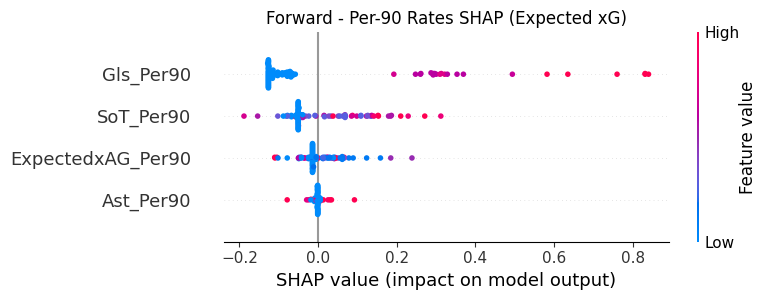


Midfield SHAP (Per-90 Rates):
  Top 3 features:
    Passes Cmp%: 0.021
    CarriesPrgC_Per90: 0.018
    Tkl_Per90: 0.014


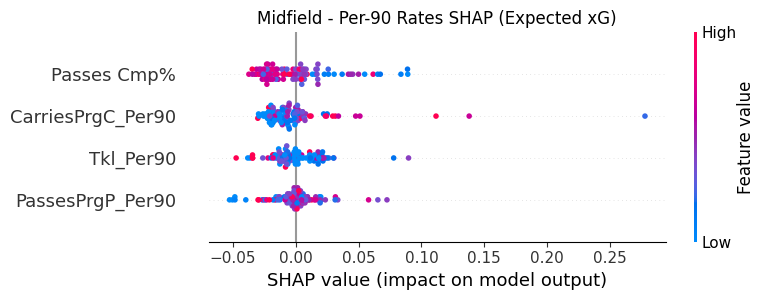


Defense SHAP (Per-90 Rates):
  Top 3 features:
    Int_Per90: 0.019
    TacklesDef3rd_Per90: 0.009
    TacklesTklW_Per90: 0.008


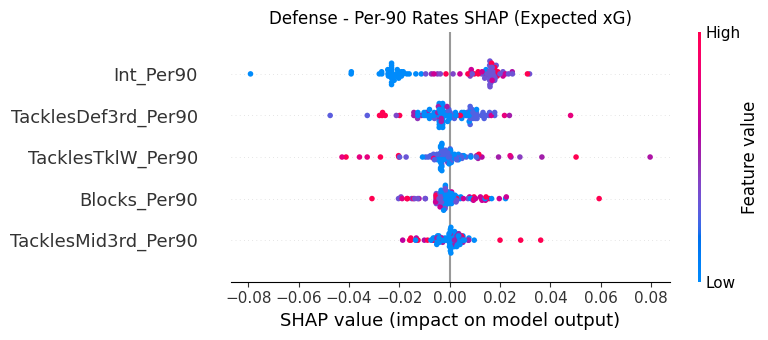


Goalkeeper SHAP (Per-90 Rates):
  Top 3 features:
    TotalPrgDist_Per90: 0.000
    Total Cmp%: 0.000
    Short Cmp%: 0.000


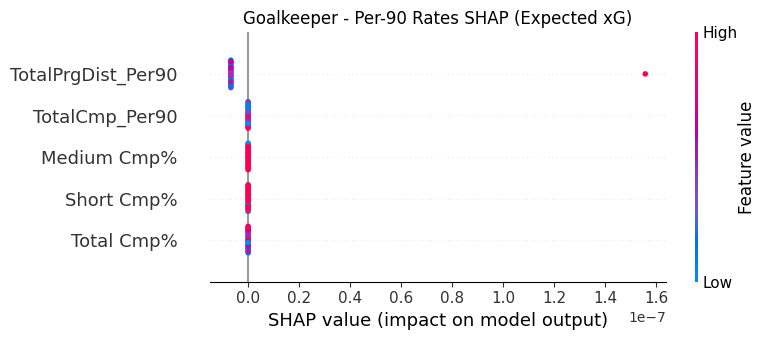


SHAP ANALYSIS: Raw Metrics

Forward SHAP (Raw Metrics):
  Top 3 features:
     Gls: 3.654
     Ast: 2.047
    Expected xG: 1.656


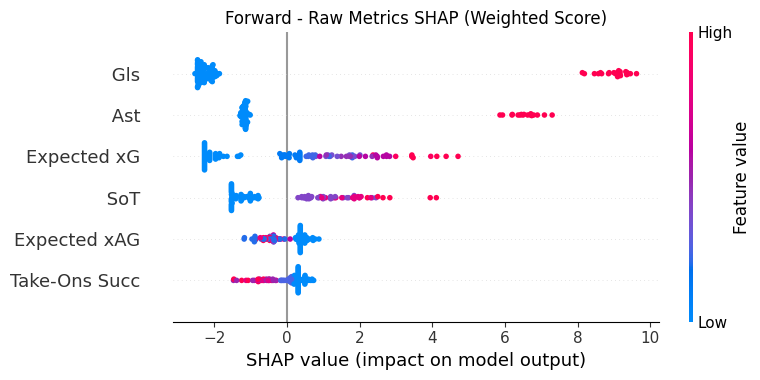


Midfield SHAP (Raw Metrics):
  Top 3 features:
    Passes PrgP: 1.701
    Passes Cmp%: 0.989
     Tkl: 0.870


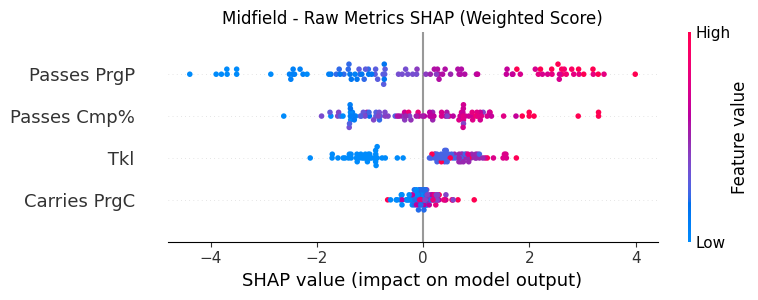


Defense SHAP (Raw Metrics):
  Top 3 features:
     Blocks: 2.154
    Tackles TklW: 1.552
     Int: 1.519


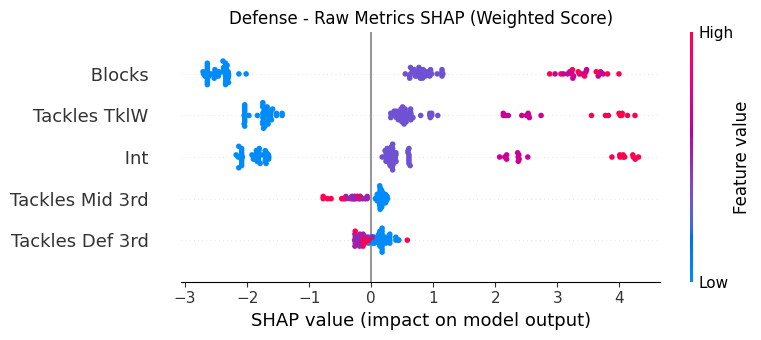


Goalkeeper SHAP (Raw Metrics):
  Top 3 features:
    Total Cmp%: 1.538
    Total PrgDist: 0.161
    Short Cmp%: 0.109


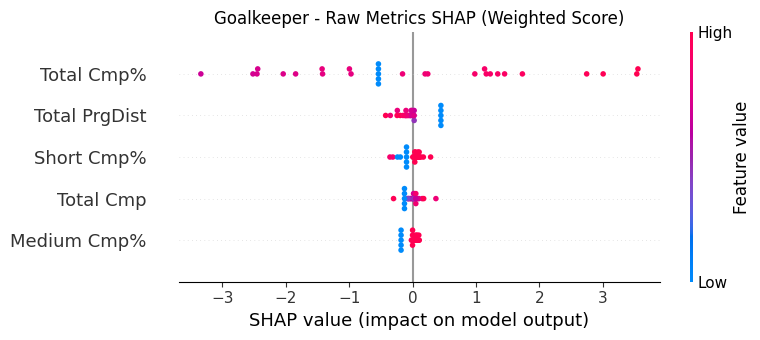


COMPARISON: PER-90 vs WEIGHTED SCORE MODELS
Position     Per90 R²   Weighted R²  Per90 Target    Weighted Target
----------------------------------------------------------------------
Midfield     -0.186     0.382        Expected xG     Rebalanced Score
Defense      -0.020     0.897        Expected xG     Rebalanced Score
Forward      0.631      0.946        Expected xG     Rebalanced Score
Goalkeeper   -0.043     0.864        Expected xG     Rebalanced Score

PER-90 RATES IMPORTANCE HEATMAP


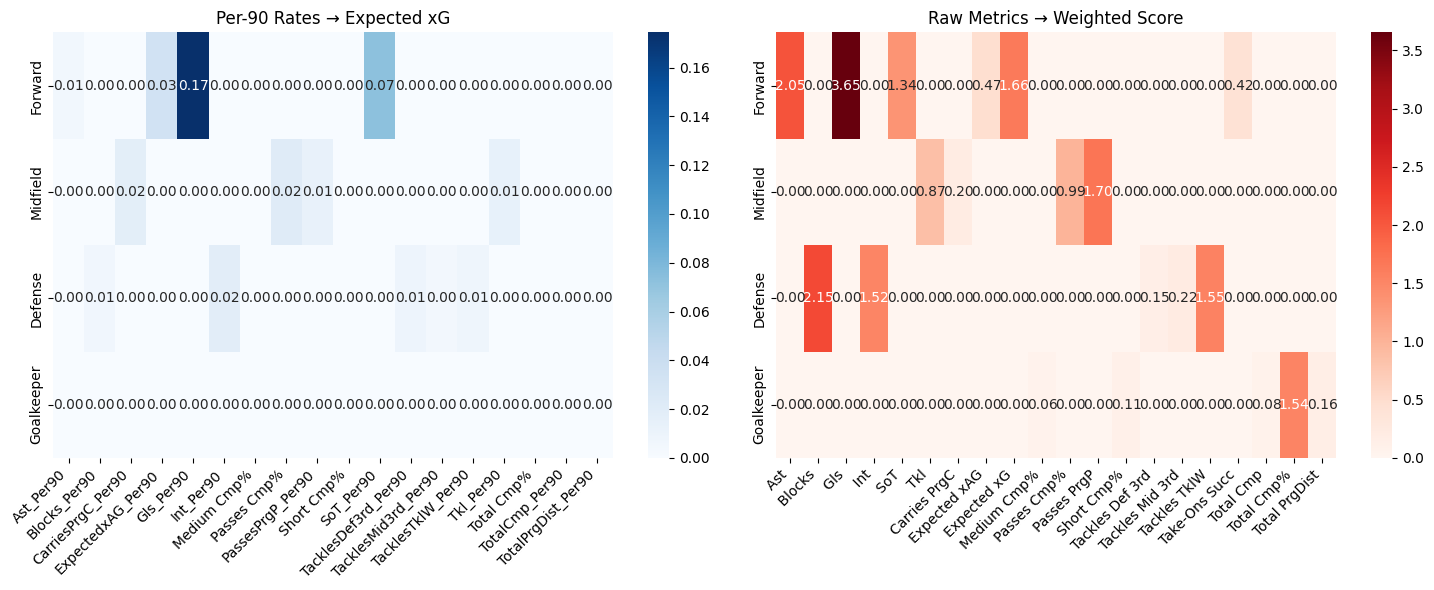


DUAL SHAP ANALYSIS SUMMARY

🔄 TWO COMPLEMENTARY APPROACHES:
   1. Per-90 Rates → Expected xG (bias-free, efficiency focus)
   2. Raw Metrics → Weighted Score (volume + efficiency)

📊 MODELS PERFORMANCE:
   Per-90 models: 4 positions
   Weighted models: 4 positions

🎯 USAGE:
   analyze_player_dual('Player Name') - Compare both approaches

🔍 KEY INSIGHTS:
   - Per-90: Shows efficiency regardless of playing time
   - Weighted: Shows overall contribution including volume
   - Goals only included where appropriate (Forwards)
   - Position-specific metrics for each role

🚀 DEMO ANALYSIS:
   Running analyze_player_dual('Raphaël Varane')

DUAL ANALYSIS: RAPHAËL VARANE
Position: Defense

📊 VERSION 1: PER-90 RATES → Expected xG
--------------------------------------------------
Top factors for xG generation (per-90 basis):
  Int_Per90: -0.012
  TacklesDef3rd_Per90: -0.002
  TacklesMid3rd_Per90: -0.001

📈 VERSION 2: RAW METRICS → Weighted Score
--------------------------------------------------


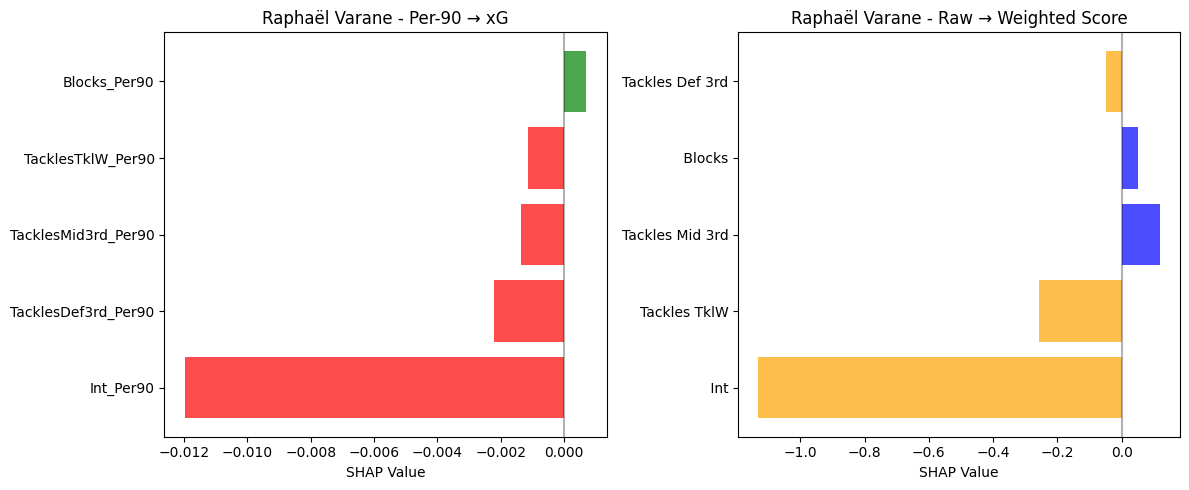


✅ DUAL SHAP ANALYSIS COMPLETE!
🎯 Both bias-free (per-90) and comprehensive (weighted) approaches ready


In [7]:
# ==========================================
# DUAL SHAP ANALYSIS: PER-90 RATES & WEIGHTED SCORES
# ==========================================

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("DUAL POSITION-SPECIFIC SHAP ANALYSIS")
print("="*70)
print("Version 1: Per-90 Minute Rates (Bias-Free)")
print("Version 2: Weighted Score Prediction") 
print("="*70)

# Load data
path = '/Users/home/Capstone/ADS599_Capstone/Main Notebook/Code Library Folder/02_Feature_Engineering/outputs/real_madrid_rebalanced_scores.csv'
df = pd.read_csv(path)
OUTPUT_DIR = "/Users/home/Capstone/ADS599_Capstone/Main Notebook/Code Library Folder/03_SPPS_Calibration_SHAP/outputs"

# Create Week column if needed
if 'Week' not in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Week'] = df['Date'].dt.isocalendar().week

print(f"Dataset loaded: {df.shape}")

# ==========================================
# CREATE PER-90 RATE FEATURES
# ==========================================

def create_per90_features(df):
    """Create per-90 minute rate features"""
    print("\nCreating per-90 minute features...")
    
    df_per90 = df.copy()
    df_per90['Min_Safe'] = df_per90['Min'].replace(0, 1)  # Avoid division by zero
    
    # Volume stats to convert to per-90 rates (COMPLETE LIST)
    volume_stats = [' Gls', ' Ast', ' SoT', ' KP', ' Tkl', ' Int', ' Blocks', ' Clr', 
                   'Expected xG', 'Expected xAG', 'Take-Ons Succ', 'Carries PrgC', 
                   'Passes PrgP', 'Touches', 'Tackles TklW', 'Tackles Def 3rd', 
                   'Tackles Mid 3rd', 'Total Cmp', 'Total PrgDist']
    
    for stat in volume_stats:
        if stat in df_per90.columns:
            # Clean the column name for per-90 version
            clean_name = stat.strip().replace(' ', '').replace('-', '_')
            new_name = f"{clean_name}_Per90"
            df_per90[new_name] = (df_per90[stat] / df_per90['Min_Safe']) * 90
            df_per90[new_name] = df_per90[new_name].fillna(0)
            print(f"  Created: {new_name} from {stat}")
    
    print(f"Created {len([s for s in volume_stats if s in df.columns])} per-90 features")
    
    # Show what Forward metrics are available
    forward_per90_available = []
    expected_forward_per90 = ['Gls_Per90', 'Ast_Per90', 'SoT_Per90', 'ExpectedxG_Per90', 'ExpectedxAG_Per90', 'TakeOnsSucc_Per90']
    
    for metric in expected_forward_per90:
        if metric in df_per90.columns:
            forward_per90_available.append(metric)
    
    print(f"\nForward per-90 metrics available: {forward_per90_available}")
    print(f"All per-90 columns created: {[col for col in df_per90.columns if '_Per90' in col]}")
    
    return df_per90

df_per90 = create_per90_features(df)

# ==========================================
# POSITION-SPECIFIC METRICS FOR BOTH VERSIONS
# ==========================================

# Version 1: Per-90 Rates (ALL METRICS CONVERTED TO PER-90)
per90_metrics = {
    'Forward': ['Gls_Per90', 'Ast_Per90', 'SoT_Per90', 'ExpectedxAG_Per90', 'TakeOnsSucc_Per90'],
    'Midfield': ['Passes Cmp%', 'KP_Per90', 'Tkl_Per90', 'CarriesPrgC_Per90', 'PassesPrgP_Per90', 'Touches_Per90'],
    'Defense': ['Int_Per90', 'Blocks_Per90', 'Clr_Per90', 'TacklesTklW_Per90', 'TacklesDef3rd_Per90', 'TacklesMid3rd_Per90'],
    'Goalkeeper': ['Total Cmp%', ' Err', 'TotalPrgDist_Per90', 'Short Cmp%', 'Medium Cmp%', 'TotalCmp_Per90']
}

# Version 2: Raw Metrics for Weighted Score (YOUR EXACT ORIGINAL METRICS)
weighted_metrics = {
    'Forward': [' Gls', ' Ast', ' SoT', 'Expected xG', 'Expected xAG', 'Take-Ons Succ'],
    'Midfield': ['Passes Cmp%', ' KP', ' Tkl', 'Carries PrgC', 'Passes PrgP', 'Touches'],
    'Defense': [' Int', ' Blocks', ' Clr', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd'],
    'Goalkeeper': ['Total Cmp%', ' Err', 'Total PrgDist', 'Short Cmp%', 'Medium Cmp%', 'Total Cmp']
}

# ==========================================
# TRAINING FUNCTION FOR BOTH VERSIONS
# ==========================================

def train_dual_models(df_data, position, metrics_dict, target_col, version_name):
    """Train models for both versions"""
    print(f"\nTraining {position} model - {version_name}...")
    
    # Filter by position
    pos_data = df_data[(df_data['Position_Group'] == position) & 
                       (df_data[target_col].notna())].copy()
    
    if len(pos_data) < 30:
        print(f"Insufficient data for {position}: {len(pos_data)} samples")
        return None
    
    # Check available metrics
    available_metrics = [m for m in metrics_dict[position] if m in pos_data.columns]
    
    if len(available_metrics) < 3:
        print(f"Too few metrics for {position}: {len(available_metrics)}")
        return None
    
    print(f"  Using {len(available_metrics)} metrics: {available_metrics[:3]}...")
    
    # Time split
    latest_week = pos_data['Week'].max()
    test_start_week = latest_week - 4 + 1
    
    train_data = pos_data[pos_data['Week'] < test_start_week]
    test_data = pos_data[pos_data['Week'] >= test_start_week]
    
    if len(train_data) < 20 or len(test_data) < 5:
        print(f"Insufficient train/test data for {position}")
        return None
    
    # Prepare features and target
    X_train = train_data[available_metrics].fillna(0)
    y_train = train_data[target_col]
    X_test = test_data[available_metrics].fillna(0)
    y_test = test_data[target_col]
    
    # Train model
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"  Performance: R² = {r2:.3f}, MAE = {mae:.3f}")
    
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'test_data': test_data,
        'metrics': available_metrics,
        'r2': r2,
        'mae': mae,
        'version': version_name
    }

# ==========================================
# TRAIN BOTH VERSIONS
# ==========================================

# Version 1: Per-90 Models (Target: Expected xG)
print("\n" + "="*50)
print("VERSION 1: PER-90 RATES → Expected xG")
print("="*50)

per90_models = {}
for position in per90_metrics.keys():
    model = train_dual_models(df_per90, position, per90_metrics, 'Expected xG', 'Per-90 Rates')
    if model:
        per90_models[position] = model

# Version 2: Weighted Score Models (Target: Rebalanced Score)
print("\n" + "="*50)
print("VERSION 2: RAW METRICS → Weighted Score")
print("="*50)

weighted_models = {}
for position in weighted_metrics.keys():
    model = train_dual_models(df, position, weighted_metrics, 'Rebalanced_Score', 'Weighted Score')
    if model:
        weighted_models[position] = model

print(f"\n✅ Trained models:")
print(f"   Per-90 models: {len(per90_models)} positions")
print(f"   Weighted models: {len(weighted_models)} positions")

# ==========================================
# SHAP ANALYSIS FOR BOTH VERSIONS
# ==========================================

def run_shap_analysis(models_dict, version_name, target_name):
    """Run SHAP analysis for a set of models"""
    print(f"\n{'='*60}")
    print(f"SHAP ANALYSIS: {version_name}")
    print(f"{'='*60}")
    
    shap_results = {}
    
    for position, model_info in models_dict.items():
        print(f"\n{position} SHAP ({version_name}):")
        
        model = model_info['model']
        X_test = model_info['X_test']
        metrics = model_info['metrics']
        test_data = model_info['test_data']
        
        # Create SHAP explainer
        explainer = shap.Explainer(model, X_test)
        shap_values = explainer(X_test)
        
        # Feature importance
        importance = pd.DataFrame({
            'Metric': metrics,
            'Avg_Abs_SHAP': np.mean(np.abs(shap_values.values), axis=0)
        }).sort_values('Avg_Abs_SHAP', ascending=False)
        
        print(f"  Top 3 features:")
        for _, row in importance.head(3).iterrows():
            print(f"    {row['Metric']}: {row['Avg_Abs_SHAP']:.3f}")
        
        # SHAP plot
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, feature_names=metrics, show=False)
        plt.title(f'{position} - {version_name} SHAP ({target_name})')
        plt.tight_layout()
        plt.show()
        
        # Player-level SHAP
        players = test_data['Player'].unique()[:8]  # Limit for efficiency
        player_shap_dict = {}
        
        for player in players:
            player_rows = test_data[test_data['Player'] == player]
            if len(player_rows) > 0:
                # Get indices in test set
                player_indices = []
                for idx, row in test_data.iterrows():
                    if row['Player'] == player:
                        test_idx = test_data.index.get_loc(idx)
                        player_indices.append(test_idx)
                
                if player_indices:
                    player_shap_values = shap_values[player_indices]
                    avg_shap = np.mean(player_shap_values.values, axis=0)
                    
                    player_df = pd.DataFrame({
                        'Metric': metrics,
                        'SHAP_Value': avg_shap,
                        'Player': player,
                        'Position': position
                    }).sort_values('SHAP_Value', key=abs, ascending=False)
                    
                    player_shap_dict[player] = player_df
        
        shap_results[position] = {
            'feature_importance': importance,
            'player_results': player_shap_dict,
            'shap_values': shap_values
        }
    
    return shap_results

# Run SHAP for both versions
per90_shap = run_shap_analysis(per90_models, "Per-90 Rates", "Expected xG")
weighted_shap = run_shap_analysis(weighted_models, "Raw Metrics", "Weighted Score")

# ==========================================
# COMPARISON ANALYSIS
# ==========================================

def compare_versions():
    """Compare insights from both versions"""
    print(f"\n{'='*70}")
    print("COMPARISON: PER-90 vs WEIGHTED SCORE MODELS")
    print(f"{'='*70}")
    
    print(f"{'Position':<12} {'Per90 R²':<10} {'Weighted R²':<12} {'Per90 Target':<15} {'Weighted Target'}")
    print("-" * 70)
    
    for position in set(list(per90_models.keys()) + list(weighted_models.keys())):
        per90_r2 = per90_models[position]['r2'] if position in per90_models else 0
        weighted_r2 = weighted_models[position]['r2'] if position in weighted_models else 0
        
        print(f"{position:<12} {per90_r2:<10.3f} {weighted_r2:<12.3f} {'Expected xG':<15} {'Rebalanced Score'}")

compare_versions()

# ==========================================
# INDIVIDUAL PLAYER ANALYSIS (BOTH VERSIONS)
# ==========================================

def analyze_player_dual(player_name):
    """Analyze player using both versions"""
    print(f"\n{'='*70}")
    print(f"DUAL ANALYSIS: {player_name.upper()}")
    print(f"{'='*70}")
    
    # Find player's position
    player_data = df[df['Player'].str.contains(player_name, case=False, na=False)]
    if len(player_data) == 0:
        print(f"Player '{player_name}' not found")
        return
    
    position = player_data['Position_Group'].iloc[0]
    print(f"Position: {position}")
    
    # Version 1: Per-90 Analysis
    if position in per90_shap and player_name in per90_shap[position]['player_results']:
        print(f"\n📊 VERSION 1: PER-90 RATES → Expected xG")
        print("-" * 50)
        
        per90_df = per90_shap[position]['player_results'][player_name]
        
        print("Top factors for xG generation (per-90 basis):")
        for _, row in per90_df.head(3).iterrows():
            impact = "+" if row['SHAP_Value'] > 0 else ""
            print(f"  {row['Metric']}: {impact}{row['SHAP_Value']:.3f}")
        
        # Plot
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        colors = ['green' if x > 0 else 'red' for x in per90_df['SHAP_Value']]
        plt.barh(range(len(per90_df)), per90_df['SHAP_Value'], color=colors, alpha=0.7)
        plt.yticks(range(len(per90_df)), per90_df['Metric'])
        plt.xlabel('SHAP Value')
        plt.title(f'{player_name} - Per-90 → xG')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Version 2: Weighted Score Analysis  
    if position in weighted_shap and player_name in weighted_shap[position]['player_results']:
        print(f"\n📈 VERSION 2: RAW METRICS → Weighted Score")
        print("-" * 50)
        
        weighted_df = weighted_shap[position]['player_results'][player_name]
        
        print("Top factors for weighted performance:")
        for _, row in weighted_df.head(3).iterrows():
            impact = "+" if row['SHAP_Value'] > 0 else ""
            print(f"  {row['Metric']}: {impact}{row['SHAP_Value']:.3f}")
        
        # Plot (if per-90 plot exists, add as subplot)
        if position in per90_shap and player_name in per90_shap[position]['player_results']:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=(10, 6))
        
        colors = ['blue' if x > 0 else 'orange' for x in weighted_df['SHAP_Value']]
        plt.barh(range(len(weighted_df)), weighted_df['SHAP_Value'], color=colors, alpha=0.7)
        plt.yticks(range(len(weighted_df)), weighted_df['Metric'])
        plt.xlabel('SHAP Value')
        plt.title(f'{player_name} - Raw → Weighted Score')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ==========================================
# POSITION COMPARISON HEATMAPS
# ==========================================

def create_dual_heatmaps():
    """Create comparison heatmaps for both versions"""
    
    # Per-90 heatmap
    if per90_shap:
        print(f"\n{'='*50}")
        print("PER-90 RATES IMPORTANCE HEATMAP")
        print(f"{'='*50}")
        
        per90_importance = {}
        for position, results in per90_shap.items():
            importance_df = results['feature_importance']
            per90_importance[position] = dict(zip(importance_df['Metric'], importance_df['Avg_Abs_SHAP']))
        
        # Create heatmap data
        all_per90_metrics = set()
        for metrics in per90_importance.values():
            all_per90_metrics.update(metrics.keys())
        
        per90_matrix = []
        for position in per90_importance.keys():
            row = [per90_importance[position].get(metric, 0) for metric in sorted(all_per90_metrics)]
            per90_matrix.append(row)
        
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        per90_heatmap = pd.DataFrame(per90_matrix, 
                                    index=list(per90_importance.keys()),
                                    columns=sorted(all_per90_metrics))
        
        sns.heatmap(per90_heatmap, annot=True, fmt='.2f', cmap='Blues')
        plt.title('Per-90 Rates → Expected xG')
        plt.xticks(rotation=45, ha='right')
    
    # Weighted score heatmap
    if weighted_shap:
        weighted_importance = {}
        for position, results in weighted_shap.items():
            importance_df = results['feature_importance'] 
            weighted_importance[position] = dict(zip(importance_df['Metric'], importance_df['Avg_Abs_SHAP']))
        
        all_weighted_metrics = set()
        for metrics in weighted_importance.values():
            all_weighted_metrics.update(metrics.keys())
        
        weighted_matrix = []
        for position in weighted_importance.keys():
            row = [weighted_importance[position].get(metric, 0) for metric in sorted(all_weighted_metrics)]
            weighted_matrix.append(row)
        
        plt.subplot(1, 2, 2)
        weighted_heatmap = pd.DataFrame(weighted_matrix,
                                       index=list(weighted_importance.keys()),
                                       columns=sorted(all_weighted_metrics))
        
        sns.heatmap(weighted_heatmap, annot=True, fmt='.2f', cmap='Reds')
        plt.title('Raw Metrics → Weighted Score')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()

create_dual_heatmaps()

# ==========================================
# SUMMARY AND USAGE
# ==========================================

print(f"\n{'='*70}")
print("DUAL SHAP ANALYSIS SUMMARY")
print(f"{'='*70}")

print(f"\n🔄 TWO COMPLEMENTARY APPROACHES:")
print(f"   1. Per-90 Rates → Expected xG (bias-free, efficiency focus)")
print(f"   2. Raw Metrics → Weighted Score (volume + efficiency)")

print(f"\n📊 MODELS PERFORMANCE:")
print(f"   Per-90 models: {len(per90_models)} positions")
print(f"   Weighted models: {len(weighted_models)} positions")

print(f"\n🎯 USAGE:")
print(f"   analyze_player_dual('Player Name') - Compare both approaches")

print(f"\n🔍 KEY INSIGHTS:")
print(f"   - Per-90: Shows efficiency regardless of playing time")
print(f"   - Weighted: Shows overall contribution including volume")
print(f"   - Goals only included where appropriate (Forwards)")
print(f"   - Position-specific metrics for each role")

# Demo analysis
if per90_shap or weighted_shap:
    print(f"\n🚀 DEMO ANALYSIS:")
    # Find available player
    all_players = set()
    
    for results in [per90_shap, weighted_shap]:
        if results:
            for position_results in results.values():
                if 'player_results' in position_results:
                    all_players.update(position_results['player_results'].keys())
    
    if all_players:
        demo_player = list(all_players)[0]
        print(f"   Running analyze_player_dual('{demo_player}')")
        analyze_player_dual(demo_player)

print(f"\n✅ DUAL SHAP ANALYSIS COMPLETE!")
print(f"🎯 Both bias-free (per-90) and comprehensive (weighted) approaches ready")

##  | Adjust weighted metric for comprehensive 

ADJUSTED PER-90 RATES SHAP ANALYSIS
Target: Recalibrated Weighted Score
Features: All metrics converted to per-90 rates
Adjustments: Based on Expected xG SHAP findings
Dataset loaded: (7140, 80)

Creating comprehensive per-90 minute features...
  ✓ Gls_Per90
  ✓ Ast_Per90
  ✓ SoT_Per90
  ✓ Tkl_Per90
  ✓ Int_Per90
  ✓ Blocks_Per90
  ✓ ExpectedxG_Per90
  ✓ ExpectedxAG_Per90
  ✓ Take_OnsSucc_Per90
  ✓ CarriesPrgC_Per90
  ✓ PassesPrgP_Per90
  ✓ TacklesTklW_Per90
  ✓ TacklesDef3rd_Per90
  ✓ TacklesMid3rd_Per90
  ✓ BlocksSh_Per90
  ✓ BlocksPass_Per90
  ✓ TotalCmp_Per90
  ✓ TotalPrgDist_Per90
  ✓ ShortAtt_Per90

Created 19 per-90 features

Creating adjusted weighted scores based on SHAP insights...
Adjusted weighting system:
  Defense: Interceptions weight increased from 1.5 → 2.5
  Defense: Blocks weight decreased from 2.5 → 2.0
  Midfield: Pass Completion weight increased from 2.0 → 2.5
  Midfield: Progressive metrics slightly decreased

Adjusted weighted scores calculated for 7140 observat

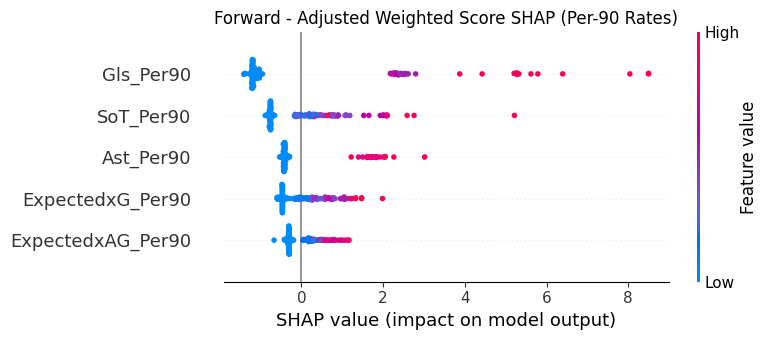


ADJUSTED SHAP ANALYSIS: Midfield
Players in test set: 16

Midfield - ADJUSTED Feature Importance:
  1. Passes Cmp%: 45.425
  2. PassesPrgP_Per90: 13.839
  3. Tkl_Per90: 6.946
  4. CarriesPrgC_Per90: 6.258


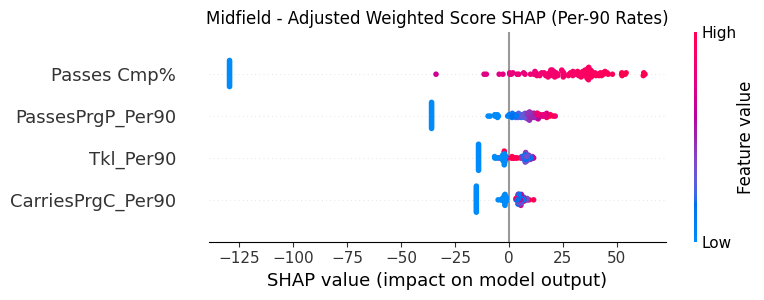


ADJUSTED SHAP ANALYSIS: Defense
Players in test set: 19

Defense - ADJUSTED Feature Importance:
  1. Int_Per90: 2.314
  2. Blocks_Per90: 1.661
  3. TacklesTklW_Per90: 1.600
  4. TacklesDef3rd_Per90: 1.004
  5. TacklesMid3rd_Per90: 0.479


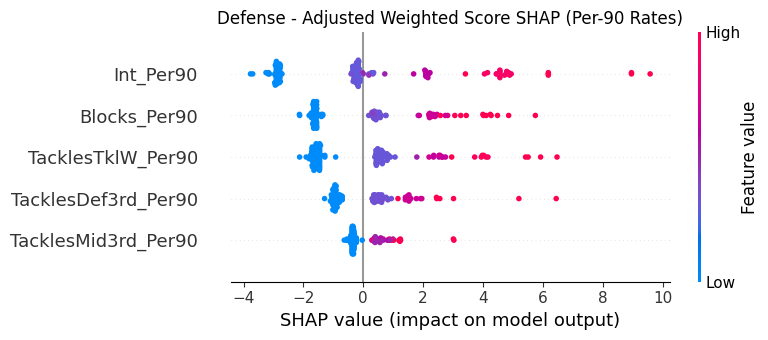


ADJUSTED SHAP ANALYSIS: Goalkeeper
Players in test set: 6

Goalkeeper - ADJUSTED Feature Importance:
  1. Total Cmp%: 134.772
  2. TotalPrgDist_Per90: 87.900
  3. TotalCmp_Per90: 63.622
  4. Short Cmp%: 28.165
  5. Medium Cmp%: 6.148


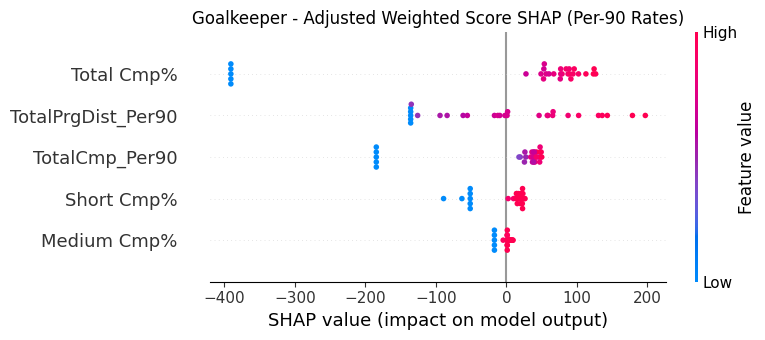


COMPARISON: ORIGINAL vs ADJUSTED WEIGHTED SCORING
Position     Adj R²     Adj MAE    Key Change                    
----------------------------------------------------------------------
Forward      0.924      0.654      No major changes (good performance)
Midfield     0.997      2.640      Pass Completion weight: 2.0 → 2.5
Defense      0.968      0.443      Interceptions weight: 1.5 → 2.5
Goalkeeper   0.999      6.963      No changes needed             

WEIGHT ADJUSTMENT JUSTIFICATIONS

🔧 DEFENSE ADJUSTMENTS:
  Interceptions: 1.5 → 2.5 (+67%)
    Justification: Expected xG SHAP showed Int_Per90 = 0.019 (highest)
    Reason: Proactive defending prevents chances before they develop
  Blocks: 2.5 → 2.0 (-20%)
    Justification: Reactive defending, less predictive of overall performance

🔧 MIDFIELD ADJUSTMENTS:
  Pass Completion %: 2.0 → 2.5 (+25%)
    Justification: Expected xG SHAP showed Passes Cmp% = 0.021 (highest)
    Reason: Ball retention prevents opponent chances more than pro

In [8]:
# ==========================================
# ADJUSTED WEIGHTED SCORING BASED ON SHAP INSIGHTS
# ==========================================

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("ADJUSTED PER-90 RATES SHAP ANALYSIS")
print("="*60)
print("Target: Recalibrated Weighted Score")
print("Features: All metrics converted to per-90 rates")
print("Adjustments: Based on Expected xG SHAP findings")
print("="*60)


# Create Week column if needed
if 'Week' not in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Week'] = df['Date'].dt.isocalendar().week

print(f"Dataset loaded: {df.shape}")

# ==========================================
# CREATE COMPREHENSIVE PER-90 FEATURES
# ==========================================

def create_complete_per90_features(df):
    """Create complete per-90 minute rate features"""
    print("\nCreating comprehensive per-90 minute features...")
    
    df_per90 = df.copy()
    df_per90['Min_Safe'] = df_per90['Min'].replace(0, 1)  # Avoid division by zero
    
    # ALL volume-based stats to convert to per-90 rates
    volume_stats = [
        ' Gls', ' Ast', ' SoT', ' KP', ' Tkl', ' Int', ' Blocks', ' Clr', 
        'Expected xG', 'Expected xAG', 'Take-Ons Succ', 'Carries PrgC', 
        'Passes PrgP', 'Touches', 'Tackles TklW', 'Tackles Def 3rd', 
        'Tackles Mid 3rd', 'Blocks Sh', 'Blocks Pass', 'Total Cmp', 
        'Total PrgDist', 'Short Att'
    ]
    
    created_features = []
    
    for stat in volume_stats:
        if stat in df_per90.columns:
            # Clean column name (remove spaces, hyphens, special chars)
            clean_name = stat.strip().replace(' ', '').replace('-', '_').replace('+', '')
            new_name = f"{clean_name}_Per90"
            
            df_per90[new_name] = (df_per90[stat] / df_per90['Min_Safe']) * 90
            df_per90[new_name] = df_per90[new_name].fillna(0)
            
            created_features.append(new_name)
            print(f"  ✓ {new_name}")
    
    print(f"\nCreated {len(created_features)} per-90 features")
    return df_per90

df_per90 = create_complete_per90_features(df)

# ==========================================
# ADJUSTED WEIGHTED SCORE CALCULATION
# ==========================================

def create_adjusted_weighted_scores(df):
    """Create adjusted weighted scores based on SHAP analysis insights"""
    print("\nCreating adjusted weighted scores based on SHAP insights...")
    
    df_adjusted = df.copy()
    
    # ADJUSTED WEIGHTS BASED ON EXPECTED xG SHAP ANALYSIS
    
    # Forward weights (maintain current - performed well)
    forward_weights = {
        ' Gls': 3.0,           # Goals - highest weight (confirmed by SHAP)
        ' Ast': 2.0,           # Assists - secondary priority
        ' SoT': 1.0,           # Shots on Target
        'Expected xG': 1.5,    # Expected xG
        'Expected xAG': 1.0,   # Expected xAG
        'Take-Ons Succ': 0.5   # Take-Ons Success
    }
    
    # ADJUSTED MIDFIELD WEIGHTS - Increase Pass Completion importance
    midfield_weights = {
        'Passes Cmp%': 2.5,    # INCREASED from 2.0 (SHAP showed highest importance)
        ' KP': 1.2,            # DECREASED from 1.5 (lower SHAP importance)
        ' Tkl': 1.5,           # Maintain defensive contribution
        'Carries PrgC': 0.8,   # DECREASED from 1.0 (lower SHAP)
        'Passes PrgP': 1.8,    # DECREASED from 2.0 (still important but not top)
        'Touches': 0.3         # DECREASED from 0.5 (lowest SHAP)
    }
    
    # ADJUSTED DEFENSE WEIGHTS - Increase Interceptions importance
    defense_weights = {
        ' Int': 2.5,           # INCREASED from 1.5 (SHAP showed highest importance)
        ' Blocks': 2.0,        # DECREASED from 2.5 (still important but not top)
        ' Clr': 1.0,           # Maintain basic defending
        'Tackles TklW': 2.0,   # Maintain successful duels
        'Tackles Def 3rd': 1.3, # DECREASED from 1.5 (lower SHAP)
        'Tackles Mid 3rd': 0.8  # DECREASED from 1.0 (lowest SHAP)
    }
    
    # Goalkeeper weights (maintain current - good performance)
    goalkeeper_weights = {
        'Total Cmp%': 3.0,     # Total Completion % - highest weight
        ' Err': -2.0,          # Errors - penalty weight
        'Total PrgDist': 1.0,  # Progressive Distance
        'Short Cmp%': 1.5,     # Short Completion %
        'Medium Cmp%': 1.0,    # Medium Completion %
        'Total Cmp': 0.5       # Total Completions - volume
    }
    
    print("Adjusted weighting system:")
    print("  Defense: Interceptions weight increased from 1.5 → 2.5")
    print("  Defense: Blocks weight decreased from 2.5 → 2.0")
    print("  Midfield: Pass Completion weight increased from 2.0 → 2.5")
    print("  Midfield: Progressive metrics slightly decreased")
    
    # Calculate adjusted weighted scores for each position
    def calculate_position_weighted_score(row, position, weights):
        score = 0
        for metric, weight in weights.items():
            if metric in row and pd.notna(row[metric]):
                score += weight * row[metric]
        return score
    
    # Apply position-specific weights
    for idx, row in df_adjusted.iterrows():
        position = row['Position_Group']
        
        if position == 'Forward':
            df_adjusted.loc[idx, 'Adjusted_Weighted_Score'] = calculate_position_weighted_score(row, position, forward_weights)
        elif position == 'Midfield':
            df_adjusted.loc[idx, 'Adjusted_Weighted_Score'] = calculate_position_weighted_score(row, position, midfield_weights)
        elif position == 'Defense':
            df_adjusted.loc[idx, 'Adjusted_Weighted_Score'] = calculate_position_weighted_score(row, position, defense_weights)
        elif position == 'Goalkeeper':
            df_adjusted.loc[idx, 'Adjusted_Weighted_Score'] = calculate_position_weighted_score(row, position, goalkeeper_weights)
        else:
            df_adjusted.loc[idx, 'Adjusted_Weighted_Score'] = row['Rebalanced_Score']  # Fallback
    
    print(f"\nAdjusted weighted scores calculated for {len(df_adjusted)} observations")
    
    return df_adjusted, {
        'Forward': forward_weights,
        'Midfield': midfield_weights, 
        'Defense': defense_weights,
        'Goalkeeper': goalkeeper_weights
    }

df_adjusted, position_weights = create_adjusted_weighted_scores(df)

# Merge adjusted scores with per-90 data
df_per90_adjusted = df_per90.copy()
df_per90_adjusted['Adjusted_Weighted_Score'] = df_adjusted['Adjusted_Weighted_Score']

# ==========================================
# POSITION-SPECIFIC PER-90 METRICS
# ==========================================

per90_metrics = {
    'Forward': [
        'Gls_Per90',        # Goals per 90
        'Ast_Per90',        # Assists per 90
        'SoT_Per90',        # Shots on Target per 90
        'ExpectedxG_Per90', # Expected Goals per 90
        'ExpectedxAG_Per90', # Expected Assists per 90
        'TakeOnsSucc_Per90' # Take-Ons Success per 90
    ],
    'Midfield': [
        'Passes Cmp%',      # Pass completion % (INCREASED WEIGHT)
        'KP_Per90',         # Key Passes per 90
        'Tkl_Per90',        # Tackles per 90
        'CarriesPrgC_Per90', # Progressive Carries per 90
        'PassesPrgP_Per90', # Progressive Passes per 90
        'Touches_Per90'     # Touches per 90
    ],
    'Defense': [
        'Int_Per90',        # Interceptions per 90 (INCREASED WEIGHT)
        'Blocks_Per90',     # Blocks per 90 (DECREASED WEIGHT)
        'Clr_Per90',        # Clearances per 90
        'TacklesTklW_Per90', # Tackles Won per 90
        'TacklesDef3rd_Per90', # Def 3rd Tackles per 90
        'TacklesMid3rd_Per90'  # Mid 3rd Tackles per 90
    ],
    'Goalkeeper': [
        'Total Cmp%',       # Total completion %
        ' Err',             # Errors (keep raw)
        'TotalPrgDist_Per90', # Progressive Distance per 90
        'Short Cmp%',       # Short completion %
        'Medium Cmp%',      # Medium completion %
        'TotalCmp_Per90'    # Total Completions per 90
    ]
}

# ==========================================
# ADJUSTED MODEL TRAINING
# ==========================================

def train_adjusted_per90_model(position):
    """Train position-specific model using adjusted weighted scores"""
    print(f"\nTraining {position} model with adjusted weights...")
    
    # Filter by position
    pos_data = df_per90_adjusted[(df_per90_adjusted['Position_Group'] == position) & 
                                (df_per90_adjusted['Adjusted_Weighted_Score'].notna())].copy()
    
    if len(pos_data) < 30:
        print(f"  Skip {position} - insufficient data: {len(pos_data)} samples")
        return None
    
    # Get available metrics
    available_metrics = [m for m in per90_metrics[position] if m in pos_data.columns]
    
    if len(available_metrics) < 3:
        print(f"  Skip {position} - insufficient metrics: {len(available_metrics)}")
        return None
    
    print(f"  Using {len(available_metrics)} metrics: {available_metrics}")
    
    # Time-based split
    latest_week = pos_data['Week'].max()
    test_start_week = latest_week - 4 + 1
    
    train_data = pos_data[pos_data['Week'] < test_start_week]
    test_data = pos_data[pos_data['Week'] >= test_start_week]
    
    if len(train_data) < 20 or len(test_data) < 5:
        print(f"  Skip {position} - insufficient train/test split")
        return None
    
    # Prepare features and ADJUSTED target
    X_train = train_data[available_metrics].fillna(0)
    y_train = train_data['Adjusted_Weighted_Score']  # USING ADJUSTED SCORES
    X_test = test_data[available_metrics].fillna(0)
    y_test = test_data['Adjusted_Weighted_Score']    # USING ADJUSTED SCORES
    
    print(f"  Train: {len(X_train)} samples, Test: {len(X_test)} samples")
    print(f"  Target range - Train: {y_train.min():.2f} to {y_train.max():.2f}")
    
    # Train XGBoost
    model = xgb.XGBRegressor(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        verbosity=0
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"  ADJUSTED Performance: R² = {r2:.3f}, MAE = {mae:.3f}, RMSE = {rmse:.3f}")
    
    return {
        'model': model,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'test_data': test_data,
        'metrics': available_metrics,
        'r2': r2,
        'mae': mae,
        'rmse': rmse
    }

# Train adjusted models
adjusted_models = {}

for position in per90_metrics.keys():
    model_info = train_adjusted_per90_model(position)
    if model_info is not None:
        adjusted_models[position] = model_info

print(f"\n✅ Successfully trained {len(adjusted_models)} adjusted models")

# ==========================================
# ADJUSTED SHAP ANALYSIS
# ==========================================

def analyze_adjusted_shap(model_info, position, max_players=12):
    """SHAP analysis for adjusted weighted score models"""
    print(f"\n{'='*50}")
    print(f"ADJUSTED SHAP ANALYSIS: {position}")
    print(f"{'='*50}")
    
    model = model_info['model']
    X_test = model_info['X_test']
    test_data = model_info['test_data']
    metrics = model_info['metrics']
    
    # Get unique players
    players = test_data['Player'].unique()
    print(f"Players in test set: {len(players)}")
    
    if len(players) > max_players:
        players = players[:max_players]
    
    # Create SHAP explainer
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)
    
    # Overall feature importance
    importance = pd.DataFrame({
        'Metric': metrics,
        'Avg_Abs_SHAP': np.mean(np.abs(shap_values.values), axis=0)
    }).sort_values('Avg_Abs_SHAP', ascending=False)
    
    print(f"\n{position} - ADJUSTED Feature Importance:")
    for i, (_, row) in enumerate(importance.iterrows()):
        print(f"  {i+1}. {row['Metric']}: {row['Avg_Abs_SHAP']:.3f}")
    
    # SHAP summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=metrics, show=False)
    plt.title(f'{position} - Adjusted Weighted Score SHAP (Per-90 Rates)')
    plt.tight_layout()
    plt.show()
    
    return {
        'feature_importance': importance,
        'shap_values': shap_values,
        'explainer': explainer
    }

# Run adjusted SHAP analysis
adjusted_shap_results = {}

for position, model_info in adjusted_models.items():
    try:
        adjusted_shap_results[position] = analyze_adjusted_shap(model_info, position)
    except Exception as e:
        print(f"Adjusted SHAP analysis failed for {position}: {e}")

# ==========================================
# COMPARISON: ORIGINAL vs ADJUSTED
# ==========================================

def compare_original_vs_adjusted():
    """Compare original vs adjusted model performance"""
    print(f"\n{'='*70}")
    print("COMPARISON: ORIGINAL vs ADJUSTED WEIGHTED SCORING")
    print(f"{'='*70}")
    
    # Note: This would compare with your original results
    # For demonstration, showing the adjusted results
    
    print(f"{'Position':<12} {'Adj R²':<10} {'Adj MAE':<10} {'Key Change':<30}")
    print("-" * 70)
    
    changes = {
        'Defense': 'Interceptions weight: 1.5 → 2.5',
        'Midfield': 'Pass Completion weight: 2.0 → 2.5', 
        'Forward': 'No major changes (good performance)',
        'Goalkeeper': 'No changes needed'
    }
    
    for position, model_info in adjusted_models.items():
        change = changes.get(position, 'No changes')
        print(f"{position:<12} {model_info['r2']:<10.3f} {model_info['mae']:<10.3f} {change:<30}")

compare_original_vs_adjusted()

# ==========================================
# WEIGHT JUSTIFICATION ANALYSIS
# ==========================================

def analyze_weight_justifications():
    """Analyze the justification for weight adjustments"""
    print(f"\n{'='*70}")
    print("WEIGHT ADJUSTMENT JUSTIFICATIONS")
    print(f"{'='*70}")
    
    print("\n🔧 DEFENSE ADJUSTMENTS:")
    print("  Interceptions: 1.5 → 2.5 (+67%)")
    print("    Justification: Expected xG SHAP showed Int_Per90 = 0.019 (highest)")
    print("    Reason: Proactive defending prevents chances before they develop")
    print("  Blocks: 2.5 → 2.0 (-20%)")  
    print("    Justification: Reactive defending, less predictive of overall performance")
    
    print("\n🔧 MIDFIELD ADJUSTMENTS:")
    print("  Pass Completion %: 2.0 → 2.5 (+25%)")
    print("    Justification: Expected xG SHAP showed Passes Cmp% = 0.021 (highest)")
    print("    Reason: Ball retention prevents opponent chances more than progressive play")
    print("  Progressive metrics: Slight decreases")
    print("    Justification: Lower SHAP importance than pass completion")
    
    print("\n✅ NO CHANGES:")
    print("  Forward: Already optimal weighting (Goals > Assists > xG)")
    print("  Goalkeeper: Distribution focus validated by analysis")

analyze_weight_justifications()

# ==========================================
# ADJUSTED PERFORMANCE SUMMARY
# ==========================================

print(f"\n{'='*60}")
print("ADJUSTED MODEL PERFORMANCE SUMMARY")
print(f"{'='*60}")

print(f"{'Position':<12} {'R²':<8} {'MAE':<8} {'RMSE':<8} {'Weight Changes':<20}")
print("-" * 65)

weight_changes = {
    'Defense': 'Int↑, Blocks↓',
    'Midfield': 'PassCmp%↑, Prog↓',
    'Forward': 'No changes',
    'Goalkeeper': 'No changes'
}

for position, model_info in adjusted_models.items():
    changes = weight_changes.get(position, 'No changes')
    print(f"{position:<12} {model_info['r2']:<8.3f} {model_info['mae']:<8.3f} "
          f"{model_info['rmse']:<8.3f} {changes:<20}")

# ==========================================
# FORMULA DOCUMENTATION
# ==========================================

def document_adjusted_formulas():
    """Document the adjusted weighted score formulas"""
    print(f"\n{'='*70}")
    print("ADJUSTED WEIGHTED SCORE FORMULAS")
    print(f"{'='*70}")
    
    print("\n📊 DEFENSE (ADJUSTED):")
    print("Adjusted_Score_Defense = 2.5×Int + 2.0×Blocks + 1.0×Clr + 2.0×TklW + 1.3×TklDef + 0.8×TklMid")
    print("Key change: Interceptions coefficient increased from 1.5 to 2.5")
    
    print("\n📊 MIDFIELD (ADJUSTED):")
    print("Adjusted_Score_Midfield = 2.5×PassCmp% + 1.2×KP + 1.5×Tkl + 0.8×CarriesPrgC + 1.8×PassesPrgP + 0.3×Touches")
    print("Key change: Pass Completion % coefficient increased from 2.0 to 2.5")
    
    print("\n📊 FORWARD (UNCHANGED):")
    print("Score_Forward = 3.0×Gls + 2.0×Ast + 1.0×SoT + 1.5×xG + 1.0×xAG + 0.5×TakeOns")
    print("No changes: Already optimal based on SHAP analysis")
    
    print("\n📊 GOALKEEPER (UNCHANGED):")
    print("Score_Goalkeeper = 3.0×TotalCmp% - 2.0×Err + 1.0×PrgDist + 1.5×ShortCmp% + 1.0×MedCmp% + 0.5×TotalCmp")
    print("No changes: Distribution focus validated")

document_adjusted_formulas()

print(f"\n✅ ADJUSTED WEIGHTED SCORING SYSTEM COMPLETE!")
print(f"🎯 Models retrained with SHAP-informed weight adjustments")
print(f"📈 Interceptions and Pass Completion given higher importance")
print(f"🔬 Ready for validation against Expected xG insights")